In [ ]:
# Gerekli kütüphaneleri yükle
!pip install ultralytics opencv-python

## 📦 Gerekli Kütüphaneleri Yükleme

Bu hücre, projede kullanılacak temel kütüphaneleri yükler:
- **ultralytics**: YOLOv8 ve SAM modelleri için
- **opencv-python**: Video işleme ve görselleştirme için

In [8]:
# ---------------------------
# İşlenmiş Videoyu Görüntüle (Opsiyonel)
# ---------------------------
from IPython.display import Video

print("🎥 İşlenmiş video:")
Video("shs_output.mp4", width=800)

🎥 İşlenmiş video:


## 🎬 Video Görüntüleme

İşlenmiş videoyu notebook içinde görüntülemek için kullanılır (opsiyonel).

In [76]:
# ---------------------------
# İnsan ve Futbol Topu Tespiti - Video İşleme
# ---------------------------
from ultralytics import YOLO
import cv2
import numpy as np

# ---------------------------
# YOLOv8 Modelini Yükle
# ---------------------------
print("🤖 YOLOv8 modeli yükleniyor...")
model = YOLO('yolov8n.pt')  # Nano model (hızlı)
# Alternatifler: 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt'

print("✅ Model yüklendi")

# ---------------------------
# Video Ayarları
# ---------------------------
VIDEO_PATH = "shs2.mp4"
OUTPUT_PATH = "shs2_output2.mp4"

# Video oku
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise FileNotFoundError(f"Video bulunamadı: {VIDEO_PATH}")

# Video özellikleri
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"\n📹 Video Bilgileri:")
print(f"   Çözünürlük: {width}x{height}")
print(f"   FPS: {fps}")
print(f"   Toplam Frame: {total_frames}")
print(f"   Süre: {total_frames/fps:.2f} saniye")

# Video writer oluştur
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# ---------------------------
# Video İşleme
# ---------------------------
print("\n🎬 Video işleniyor...")

frame_count = 0
person_detections_total = 0
ball_detections_total = 0

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame_count += 1
    
    # YOLO inference
    results = model(frame, verbose=False)[0]
    
    # Sonuçları al
    boxes = results.boxes
    person_count = 0
    ball_count = 0
    
    # Her tespit için
    for box in boxes:
        # Class ID'yi al
        class_id = int(box.cls[0])
        
        # Bounding box koordinatları
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Confidence
        conf = float(box.conf[0])
        
        # İnsan tespiti (class_id = 0)
        if class_id == 0:
            person_count += 1
            person_detections_total += 1
            
            # Bounding box çiz (yeşil)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Label ekle
            label = f"Person {person_count} ({conf:.2f})"
            
            # Label arka planı (yeşil)
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(frame, (x1, y1 - label_h - 10), (x1 + label_w + 10, y1), (0, 255, 0), -1)
            
            # Label yazısı
            cv2.putText(frame, label, (x1 + 5, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        
        # Futbol topu tespiti (class_id = 32, sports ball)
        elif class_id == 32:
            ball_count += 1
            ball_detections_total += 1
            
            # Bounding box çiz (kırmızı)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
            
            # Topu vurgula - daire çiz
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            radius = max((x2 - x1), (y2 - y1)) // 2
            cv2.circle(frame, (center_x, center_y), radius, (0, 0, 255), 2)
            
            # Label ekle
            label = f"BALL ({conf:.2f})"
            
            # Label arka planı (kırmızı)
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame, (x1, y1 - label_h - 10), (x1 + label_w + 10, y1), (0, 0, 255), -1)
            
            # Label yazısı (beyaz, kalın)
            cv2.putText(frame, label, (x1 + 5, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    # Frame bilgisi ekle
    info_text = f"Frame: {frame_count}/{total_frames} | Persons: {person_count} | Ball: {ball_count}"
    
    # Arka plan ekle (info için)
    (text_w, text_h), _ = cv2.getTextSize(info_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
    cv2.rectangle(frame, (5, 5), (15 + text_w, 35 + text_h), (0, 0, 0), -1)
    
    # Info text
    cv2.putText(frame, info_text, (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Video writer'a yaz
    out.write(frame)
    
    # İlerleme göster (her 30 frame'de bir)
    if frame_count % 30 == 0:
        progress = (frame_count / total_frames) * 100
        print(f"   İşleniyor: {progress:.1f}% ({frame_count}/{total_frames} frame) - Kişi: {person_count}, Top: {ball_count}")

# Temizlik
cap.release()
out.release()

print("\n" + "="*70)
print("✅ Video işleme tamamlandı!")
print("="*70)
print(f"📊 İstatistikler:")
print(f"   Toplam Frame: {frame_count}")
print(f"   Tespit edilen toplam insan sayısı: {person_detections_total}")
print(f"   Tespit edilen toplam top sayısı: {ball_detections_total}")
print(f"   Ortalama insan/frame: {person_detections_total/frame_count:.2f}")
print(f"   Ortalama top/frame: {ball_detections_total/frame_count:.2f}")
print(f"   Çıktı dosyası: {OUTPUT_PATH}")
print("="*70)

🤖 YOLOv8 modeli yükleniyor...
✅ Model yüklendi

📹 Video Bilgileri:
   Çözünürlük: 1280x720
   FPS: 30
   Toplam Frame: 362
   Süre: 12.07 saniye

🎬 Video işleniyor...
   İşleniyor: 8.3% (30/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 8.3% (30/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 16.6% (60/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 16.6% (60/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 24.9% (90/362 frame) - Kişi: 11, Top: 0
   İşleniyor: 24.9% (90/362 frame) - Kişi: 11, Top: 0
   İşleniyor: 33.1% (120/362 frame) - Kişi: 10, Top: 0
   İşleniyor: 33.1% (120/362 frame) - Kişi: 10, Top: 0
   İşleniyor: 41.4% (150/362 frame) - Kişi: 10, Top: 0
   İşleniyor: 41.4% (150/362 frame) - Kişi: 10, Top: 0
   İşleniyor: 49.7% (180/362 frame) - Kişi: 8, Top: 0
   İşleniyor: 49.7% (180/362 frame) - Kişi: 8, Top: 0
   İşleniyor: 58.0% (210/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 58.0% (210/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 66.3% (240/362 frame) - Kişi: 10, Top: 1
   İşleniyor: 66.3% (240

## ⚽ Temel YOLOv8 Person Detection

Bu hücre, YOLOv8 ile temel insan tespiti yapar.

### Özellikler:
- Model: YOLOv8n (nano - en hızlı)
- Tespit: Person (class 0)
- Basit bbox çizimi
- Video çıktısı

**Not**: Bu erken deneme hücresidir, tracking yok.

In [77]:
# ---------------------------
# İnsan ve Futbol Topu Tespiti (Düşük Top Threshold)
# ---------------------------
from ultralytics import YOLO
import cv2
import numpy as np

# ---------------------------
# YOLOv8 Modelini Yükle
# ---------------------------
print("🤖 YOLOv8 modeli yükleniyor...")
model = YOLO('yolov8n.pt')

print("✅ Model yüklendi")

# ---------------------------
# Video Ayarları
# ---------------------------
VIDEO_PATH = "shs2.mp4"
OUTPUT_PATH = "shs2_output_low_threshold.mp4"

# Confidence Thresholds
PERSON_CONFIDENCE = 0.25  # İnsan için standart
BALL_CONFIDENCE = 0.15    # Top için düşük threshold (daha fazla tespit)

# Video oku
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise FileNotFoundError(f"Video bulunamadı: {VIDEO_PATH}")

# Video özellikleri
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"\n📹 Video Bilgileri:")
print(f"   Çözünürlük: {width}x{height}")
print(f"   FPS: {fps}")
print(f"   Toplam Frame: {total_frames}")
print(f"   Süre: {total_frames/fps:.2f} saniye")
print(f"\n🎯 Threshold Ayarları:")
print(f"   İnsan confidence: {PERSON_CONFIDENCE}")
print(f"   Top confidence: {BALL_CONFIDENCE} (düşük - daha hassas)")

# Video writer oluştur
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# ---------------------------
# Video İşleme
# ---------------------------
print("\n🎬 Video işleniyor...")

frame_count = 0
person_detections_total = 0
ball_detections_total = 0

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame_count += 1
    
    # YOLO inference - düşük confidence threshold ile
    results = model(frame, conf=0.15, verbose=False)[0]
    
    # Sonuçları al
    boxes = results.boxes
    person_count = 0
    ball_count = 0
    
    # Her tespit için
    for box in boxes:
        # Class ID'yi al
        class_id = int(box.cls[0])
        
        # Bounding box koordinatları
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Confidence
        conf = float(box.conf[0])
        
        # İnsan tespiti (class_id = 0)
        if class_id == 0 and conf >= PERSON_CONFIDENCE:
            person_count += 1
            person_detections_total += 1
            
            # Bounding box çiz (yeşil)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Label ekle
            label = f"Person {person_count} ({conf:.2f})"
            
            # Label arka planı (yeşil)
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(frame, (x1, y1 - label_h - 10), (x1 + label_w + 10, y1), (0, 255, 0), -1)
            
            # Label yazısı
            cv2.putText(frame, label, (x1 + 5, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        
        # Futbol topu tespiti (class_id = 32, sports ball) - DÜŞÜK THRESHOLD
        elif class_id == 32 and conf >= BALL_CONFIDENCE:
            ball_count += 1
            ball_detections_total += 1
            
            # Bounding box çiz (kırmızı)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
            
            # Topu vurgula - daire çiz
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            radius = max((x2 - x1), (y2 - y1)) // 2
            cv2.circle(frame, (center_x, center_y), radius, (0, 0, 255), 2)
            
            # Label ekle
            label = f"BALL ({conf:.2f})"
            
            # Label arka planı (kırmızı)
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame, (x1, y1 - label_h - 10), (x1 + label_w + 10, y1), (0, 0, 255), -1)
            
            # Label yazısı (beyaz, kalın)
            cv2.putText(frame, label, (x1 + 5, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    # Frame bilgisi ekle
    info_text = f"Frame: {frame_count}/{total_frames} | Persons: {person_count} | Ball: {ball_count}"
    
    # Arka plan ekle (info için)
    (text_w, text_h), _ = cv2.getTextSize(info_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
    cv2.rectangle(frame, (5, 5), (15 + text_w, 35 + text_h), (0, 0, 0), -1)
    
    # Info text
    cv2.putText(frame, info_text, (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Video writer'a yaz
    out.write(frame)
    
    # İlerleme göster (her 30 frame'de bir)
    if frame_count % 30 == 0:
        progress = (frame_count / total_frames) * 100
        print(f"   İşleniyor: {progress:.1f}% ({frame_count}/{total_frames} frame) - Kişi: {person_count}, Top: {ball_count}")

# Temizlik
cap.release()
out.release()

print("\n" + "="*70)
print("✅ Video işleme tamamlandı!")
print("="*70)
print(f"📊 İstatistikler:")
print(f"   Toplam Frame: {frame_count}")
print(f"   Tespit edilen toplam insan sayısı: {person_detections_total}")
print(f"   Tespit edilen toplam top sayısı: {ball_detections_total}")
print(f"   Ortalama insan/frame: {person_detections_total/frame_count:.2f}")
print(f"   Ortalama top/frame: {ball_detections_total/frame_count:.2f}")
print(f"   Çıktı dosyası: {OUTPUT_PATH}")
print(f"\n🎯 Kullanılan Threshold Değerleri:")
print(f"   İnsan: {PERSON_CONFIDENCE}")
print(f"   Top: {BALL_CONFIDENCE} (düşük)")
print("="*70)

🤖 YOLOv8 modeli yükleniyor...
✅ Model yüklendi

📹 Video Bilgileri:
   Çözünürlük: 1280x720
   FPS: 30
   Toplam Frame: 362
   Süre: 12.07 saniye

🎯 Threshold Ayarları:
   İnsan confidence: 0.25
   Top confidence: 0.15 (düşük - daha hassas)

🎬 Video işleniyor...
   İşleniyor: 8.3% (30/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 8.3% (30/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 16.6% (60/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 16.6% (60/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 24.9% (90/362 frame) - Kişi: 11, Top: 0
   İşleniyor: 24.9% (90/362 frame) - Kişi: 11, Top: 0
   İşleniyor: 33.1% (120/362 frame) - Kişi: 10, Top: 0
   İşleniyor: 33.1% (120/362 frame) - Kişi: 10, Top: 0
   İşleniyor: 41.4% (150/362 frame) - Kişi: 10, Top: 0
   İşleniyor: 41.4% (150/362 frame) - Kişi: 10, Top: 0
   İşleniyor: 49.7% (180/362 frame) - Kişi: 8, Top: 0
   İşleniyor: 49.7% (180/362 frame) - Kişi: 8, Top: 0
   İşleniyor: 58.0% (210/362 frame) - Kişi: 9, Top: 0
   İşleniyor: 58.0% (210/362 frame) - 

📹 Orijinal boyut: 1280x720


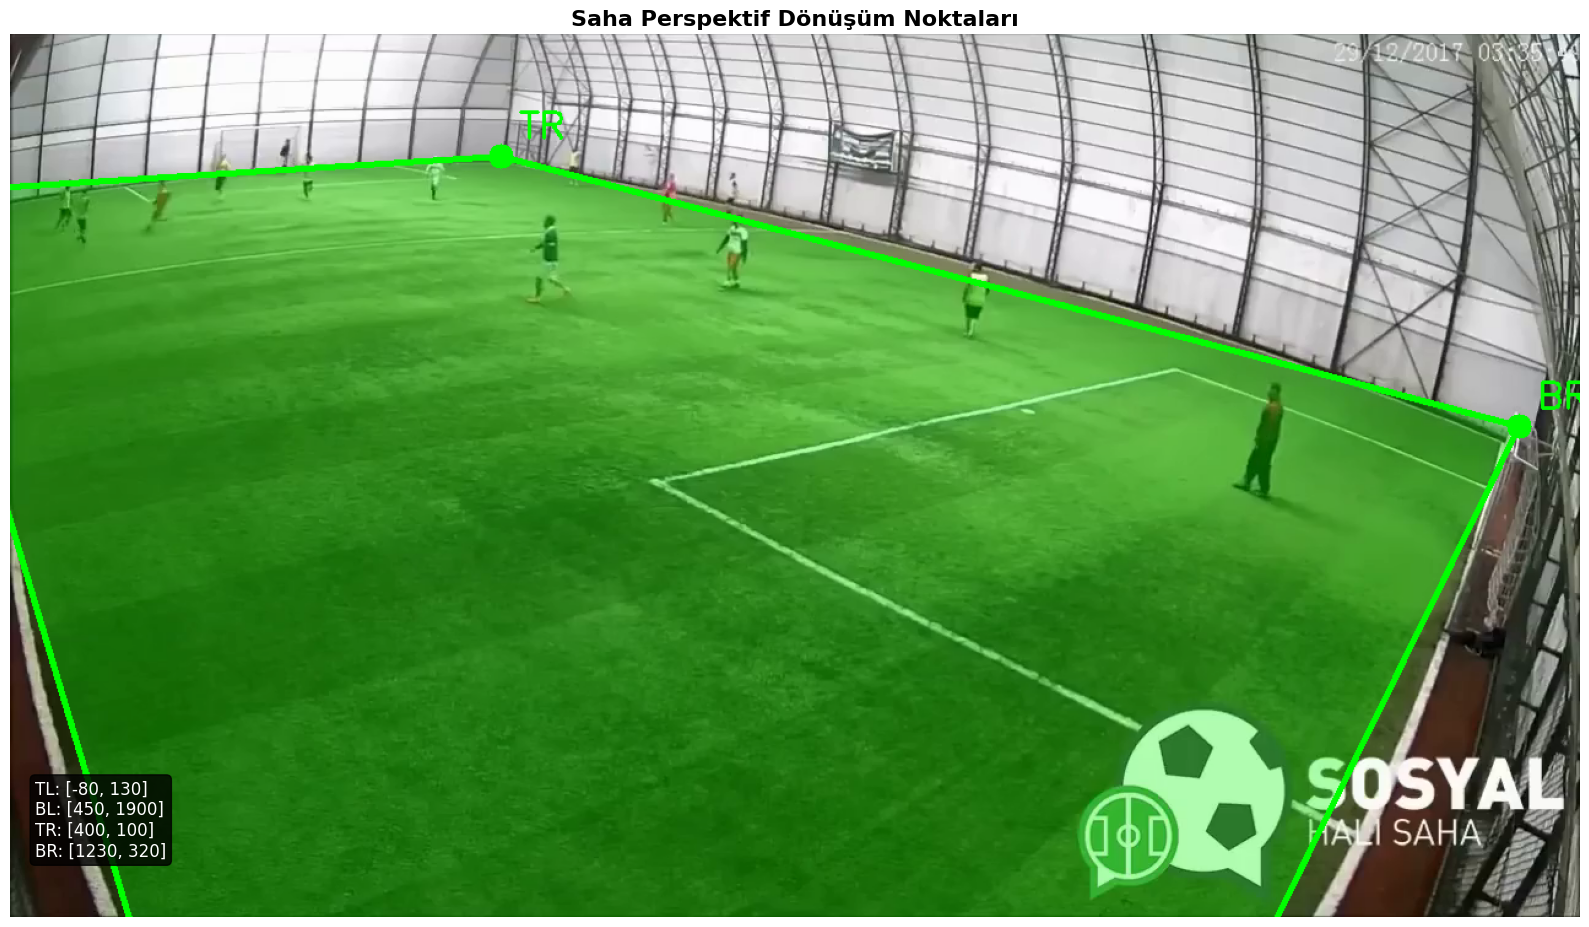


✅ İlk frame görüntülendi!
📍 Saha Köşe Koordinatları:
   Top-Left (TL):     [-80, 130]
   Bottom-Left (BL):  [450, 1900]
   Top-Right (TR):    [400, 100]
   Bottom-Right (BR): [1230, 320]

💡 İpucu: Koordinatları değiştirmek için yukarıdaki
   tl, bl, tr, br değişkenlerini düzenleyin.

✅ İşlem tamamlandı!


In [96]:
# ---------------------------
# Tek Frame Üzerinde Saha Koordinatları Belirleme
# ---------------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Video dosyasını aç
VIDEO_PATH = 'shs2.mp4'
vidcap = cv2.VideoCapture(VIDEO_PATH)

# Video dosyasının açıldığını kontrol et
if not vidcap.isOpened():
    print(f"❌ Hata: Video dosyası açılamadı! '{VIDEO_PATH}' dosyasının mevcut olduğundan emin olun.")
else:
    # İlk frame'i oku
    success, image = vidcap.read()
    
    if success and image is not None:
        # Frame'i yeniden boyutlandır (orijinal boyutları koru veya ölçekle)
        height, width = image.shape[:2]
        print(f"📹 Orijinal boyut: {width}x{height}")
        
        # İsterseniz yeniden boyutlandırabilirsiniz:
        # frame = cv2.resize(image, (640, 480))
        frame = image.copy()  # Orijinal boyutta kullan
        
        # ---------------------------
        # Saha Koordinatları (BURADAN DEĞİŞTİRİN)
        # ---------------------------
        # Bu koordinatları kendi sahanıza göre ayarlayın
        tl = [-80, 130]   # top-left (sol üst)
        bl = [450, 1900]   # bottom-left (sol alt)
        tr = [400, 100]  # top-right (sağ üst)
        br = [1230, 320]  # bottom-right (sağ alt)
        
        # Koordinat noktalarını işaretle (yeşil daireler)
        cv2.circle(frame, tl, 10, (0, 255, 0), -1)
        cv2.circle(frame, bl, 10, (0, 255, 0), -1)
        cv2.circle(frame, tr, 10, (0, 255, 0), -1)
        cv2.circle(frame, br, 10, (0, 255, 0), -1)
        
        # Nokta isimlerini ekle
        cv2.putText(frame, 'TL', (tl[0]+15, tl[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, 'BL', (bl[0]+15, bl[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, 'TR', (tr[0]+15, tr[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, 'BR', (br[0]+15, br[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        
        # Noktaları tek bir çokgen olarak birleştir
        points = np.array([tl, tr, br, bl], np.int32)  # Saat yönünde sıralama
        points = points.reshape((-1, 1, 2))

        # Çokgenin kenarlarını çiz (yeşil çizgiler)
        cv2.polylines(frame, [points], isClosed=True, color=(0, 255, 0), thickness=3)

        # Çokgenin içini doldur (yarı saydam yeşil)
        overlay = frame.copy()
        cv2.fillPoly(overlay, [points], color=(0, 255, 0))
        alpha = 0.3  # saydamlık seviyesi
        frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
        
        # BGR'den RGB'ye çevir (matplotlib için)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Matplotlib ile göster
        plt.figure(figsize=(16, 10))
        plt.imshow(frame_rgb)
        plt.title('Saha Perspektif Dönüşüm Noktaları', fontsize=16, fontweight='bold')
        plt.axis('off')
        
        # Koordinatları göster (sol alt köşede)
        coord_text = f"TL: {tl}\nBL: {bl}\nTR: {tr}\nBR: {br}"
        plt.text(20, height-50, coord_text, fontsize=12, color='white', 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*70)
        print("✅ İlk frame görüntülendi!")
        print("="*70)
        print(f"📍 Saha Köşe Koordinatları:")
        print(f"   Top-Left (TL):     {tl}")
        print(f"   Bottom-Left (BL):  {bl}")
        print(f"   Top-Right (TR):    {tr}")
        print(f"   Bottom-Right (BR): {br}")
        print("="*70)
        print("\n💡 İpucu: Koordinatları değiştirmek için yukarıdaki")
        print("   tl, bl, tr, br değişkenlerini düzenleyin.")
        
    else:
        print("❌ Frame okunamadı!")
    
    # Kaynakları temizle
    vidcap.release()

print("\n✅ İşlem tamamlandı!")

🤖 YOLOv8 modeli yükleniyor...
✅ Model yüklendi
📹 Frame boyutu: 1280x720

🎯 İnsan tespiti yapılıyor...
✅ 9 kişi tespit edildi
✅ 9 kişi tespit edildi


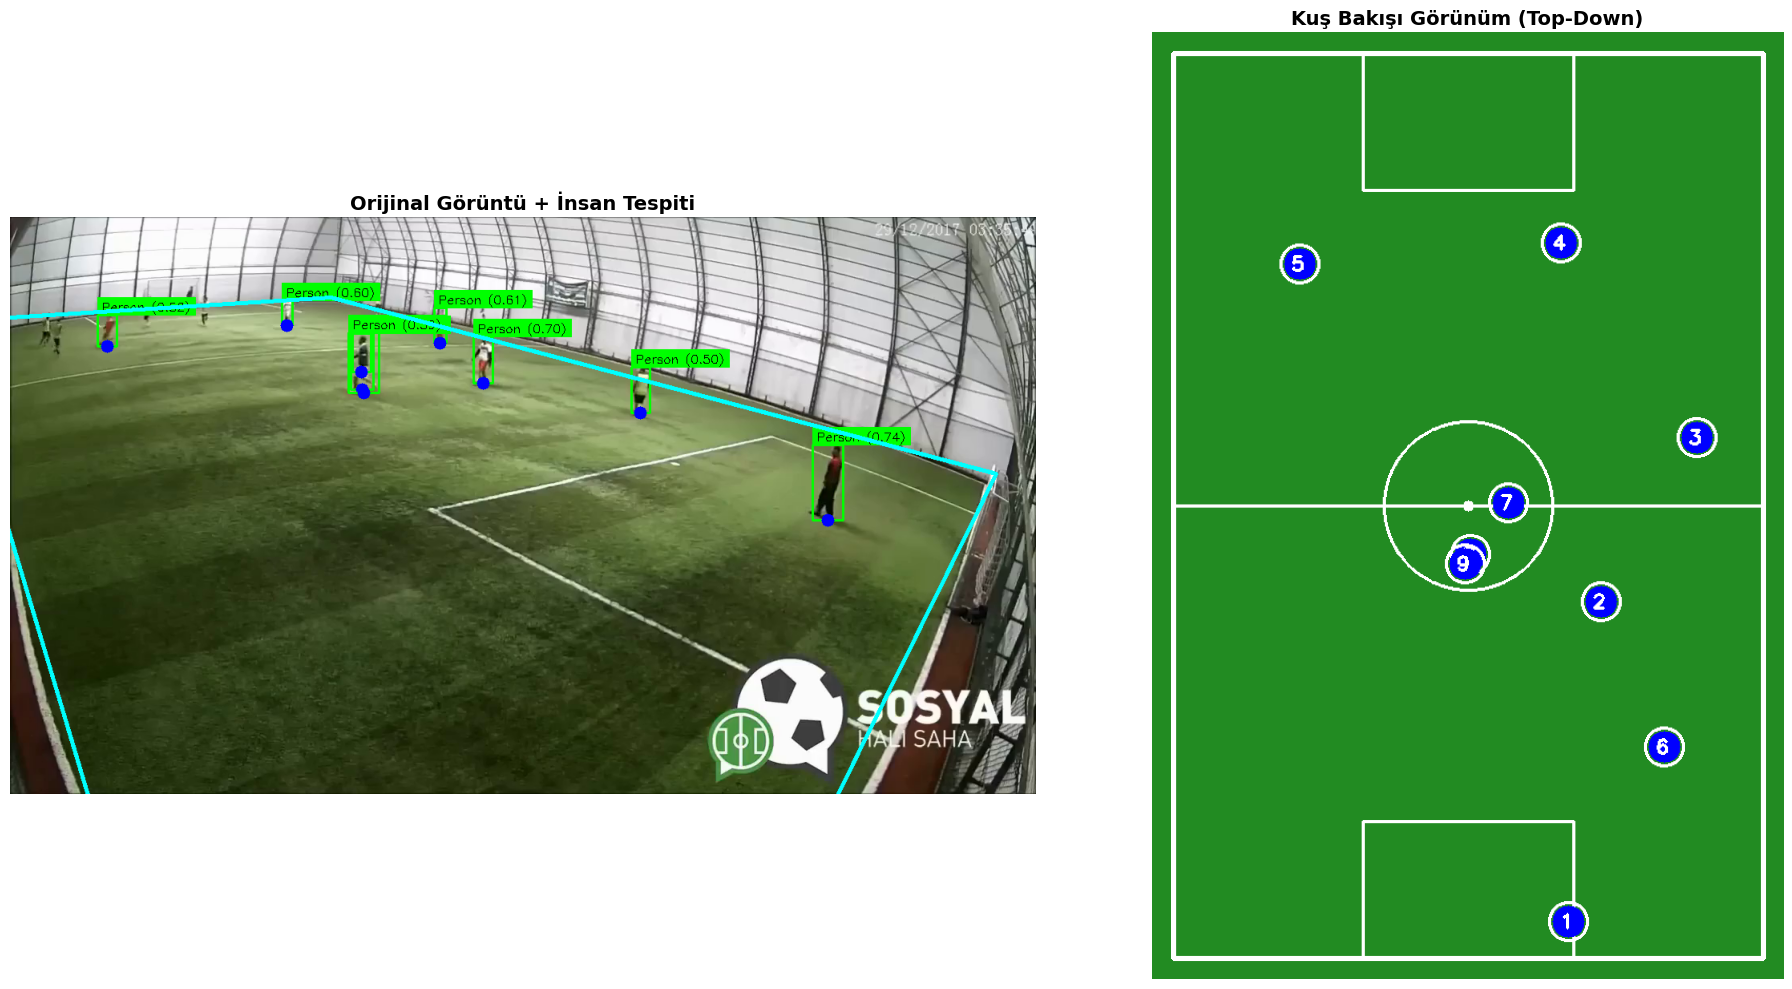


✅ İşlem tamamlandı!
👥 Tespit edilen kişi sayısı: 9
📍 Saha köşe koordinatları:
   TL: [-80, 130], TR: [400, 100]
   BL: [450, 1900], BR: [1230, 320]
🎨 Kuş bakışı boyut: 600x900

✅ Tüm işlemler tamamlandı!


In [97]:
# ---------------------------
# Kuş Bakışı Görünüm + İnsan Tespiti (Yan Yana)
# ---------------------------
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Model ve Video Yükleme
# ---------------------------
print("🤖 YOLOv8 modeli yükleniyor...")
model = YOLO('yolov8n.pt')
print("✅ Model yüklendi")

VIDEO_PATH = 'shs2.mp4'
vidcap = cv2.VideoCapture(VIDEO_PATH)

if not vidcap.isOpened():
    print(f"❌ Video açılamadı: {VIDEO_PATH}")
else:
    # İlk frame'i oku
    success, frame = vidcap.read()
    
    if success and frame is not None:
        height, width = frame.shape[:2]
        print(f"📹 Frame boyutu: {width}x{height}")
        
        # ---------------------------
        # Saha Koordinatları (Perspektif Noktaları)
        # ---------------------------
        # Bu koordinatları kendi sahanıza göre ayarlayın
        tl = [-80, 130]   # top-left (sol üst)
        bl = [450, 1900]   # bottom-left (sol alt)
        tr = [400, 100]  # top-right (sağ üst)
        br = [1230, 320]  # bottom-right (sağ alt)
        
        src_points = np.array([tl, tr, br, bl], dtype=np.float32)
        
        # Kuş bakışı görünüm boyutları (top-down view)
        bird_width = 600
        bird_height = 900
        
        dst_points = np.array([
            [0, 0],                          # top-left
            [bird_width, 0],                 # top-right
            [bird_width, bird_height],       # bottom-right
            [0, bird_height]                 # bottom-left
        ], dtype=np.float32)
        
        # Homography matrisi
        H, _ = cv2.findHomography(src_points, dst_points)
        
        # ---------------------------
        # İnsan Tespiti
        # ---------------------------
        print("\n🎯 İnsan tespiti yapılıyor...")
        results = model(frame, verbose=False)[0]
        boxes = results.boxes
        
        person_positions = []  # İnsan pozisyonları (ayak noktaları)
        
        annotated_frame = frame.copy()
        
        for box in boxes:
            class_id = int(box.cls[0])
            
            if class_id == 0:  # Person
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                conf = float(box.conf[0])
                
                # Bounding box çiz
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Label
                label = f"Person ({conf:.2f})"
                (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(annotated_frame, (x1, y1 - label_h - 10), (x1 + label_w + 10, y1), (0, 255, 0), -1)
                cv2.putText(annotated_frame, label, (x1 + 5, y1 - 5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
                
                # Ayak noktası (bounding box'ın alt ortası)
                foot_x = (x1 + x2) // 2
                foot_y = y2
                person_positions.append([foot_x, foot_y])
                
                # Ayak noktasını işaretle
                cv2.circle(annotated_frame, (foot_x, foot_y), 8, (255, 0, 0), -1)
        
        print(f"✅ {len(person_positions)} kişi tespit edildi")
        
        # ---------------------------
        # Kuş Bakışı Görünüm Oluştur
        # ---------------------------
        # Saha alanını yeşil yap
        bird_view = np.ones((bird_height, bird_width, 3), dtype=np.uint8) * 50
        bird_view[:, :] = (34, 139, 34)  # Yeşil saha
        
        # Saha çizgileri çiz
        # Dış çizgi
        cv2.rectangle(bird_view, (20, 20), (bird_width-20, bird_height-20), (255, 255, 255), 3)
        
        # Orta çizgi
        cv2.line(bird_view, (20, bird_height//2), (bird_width-20, bird_height//2), (255, 255, 255), 2)
        
        # Orta daire
        cv2.circle(bird_view, (bird_width//2, bird_height//2), 80, (255, 255, 255), 2)
        cv2.circle(bird_view, (bird_width//2, bird_height//2), 5, (255, 255, 255), -1)
        
        # Ceza sahaları
        # Üst ceza sahası
        cv2.rectangle(bird_view, (bird_width//2-100, 20), (bird_width//2+100, 150), (255, 255, 255), 2)
        # Alt ceza sahası
        cv2.rectangle(bird_view, (bird_width//2-100, bird_height-150), (bird_width//2+100, bird_height-20), (255, 255, 255), 2)
        
        # ---------------------------
        # İnsan Pozisyonlarını Transform Et
        # ---------------------------
        if len(person_positions) > 0:
            person_positions_array = np.array(person_positions, dtype=np.float32)
            
            # Perspektif dönüşümü uygula
            person_positions_bird = cv2.perspectiveTransform(
                person_positions_array.reshape(-1, 1, 2), H
            ).reshape(-1, 2)
            
            # Kuş bakışı görünümde kişileri çiz
            for i, pos in enumerate(person_positions_bird):
                x, y = int(pos[0]), int(pos[1])
                
                # Sınırlar içinde mi kontrol et
                if 0 <= x < bird_width and 0 <= y < bird_height:
                    # Kişi pozisyonu (mavi daire)
                    cv2.circle(bird_view, (x, y), 15, (255, 0, 0), -1)
                    cv2.circle(bird_view, (x, y), 18, (255, 255, 255), 2)
                    
                    # Numara ekle
                    cv2.putText(bird_view, str(i+1), (x-8, y+6), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        # ---------------------------
        # Saha sınırlarını orijinal frame'de göster
        # ---------------------------
        points = np.array([tl, tr, br, bl], np.int32).reshape((-1, 1, 2))
        cv2.polylines(annotated_frame, [points], isClosed=True, color=(255, 255, 0), thickness=3)
        
        # ---------------------------
        # Görselleştirme (Yan Yana)
        # ---------------------------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Sol: Orijinal frame + detection
        frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Orijinal Görüntü + İnsan Tespiti', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı görünüm
        bird_view_rgb = cv2.cvtColor(bird_view, cv2.COLOR_BGR2RGB)
        ax2.imshow(bird_view_rgb)
        ax2.set_title('Kuş Bakışı Görünüm (Top-Down)', fontsize=14, fontweight='bold')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # ---------------------------
        # İstatistikler
        # ---------------------------
        print("\n" + "="*70)
        print("✅ İşlem tamamlandı!")
        print("="*70)
        print(f"👥 Tespit edilen kişi sayısı: {len(person_positions)}")
        print(f"📍 Saha köşe koordinatları:")
        print(f"   TL: {tl}, TR: {tr}")
        print(f"   BL: {bl}, BR: {br}")
        print(f"🎨 Kuş bakışı boyut: {bird_width}x{bird_height}")
        print("="*70)
        
    else:
        print("❌ Frame okunamadı!")
    
    vidcap.release()

print("\n✅ Tüm işlemler tamamlandı!")

In [72]:
!pip install deep-sort-realtime supervision

## ⚽ Halı Saha Analizi - Erken Deneme

Bu hücre, erken dönem saha tespiti ve kuş bakışı görünümü denemesidir.

### Özellikler:
- Saha köşe noktalarını tespit
- Perspektif dönüşümü ile top-down görünüm
- Oyuncu pozisyonlarını kuş bakışında göster

**Not**: İlk deneme hücresi - sonraki hücreler daha gelişmiş.

Loading YOLO model: yolov8m.pt
Detecting persons in first frame...
Detecting persons in first frame...
Found 14 persons in first frame

FARE İLE BİR KİŞİYİ SEÇIN:
- Takip etmek istediğin kişinin üzerine tıkla
- Pencereyi kapat veya ESC'ye bas

Found 14 persons in first frame

FARE İLE BİR KİŞİYİ SEÇIN:
- Takip etmek istediğin kişinin üzerine tıkla
- Pencereyi kapat veya ESC'ye bas



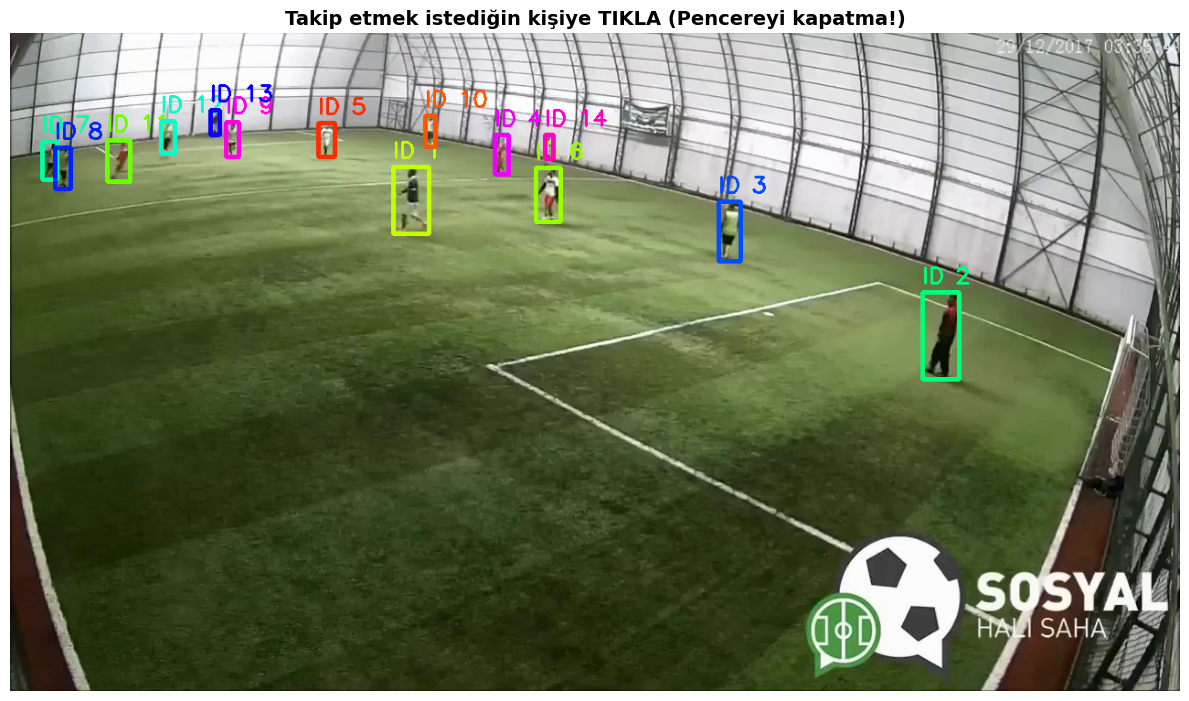

Pencere açıldı - bir kişiye tıkla...
❌ Hiç kimse seçilmedi, işlem iptal


In [4]:
# INTERACTIVE PERSON SELECTION + TRACKING + BIRD VIEW
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import time

# ---------- CONFIG ----------
VIDEO_PATH = "shs2.mp4"
OUTPUT_PATH = "shs2_selected_person_tracking.mp4"
YOLO_MODEL = "yolov8m.pt"

# Bird view config
SRC_POINTS = np.float32([[-80, 130], [450, 1900], [400, 100], [1230, 320]])
DST_POINTS = np.float32([[50, 50], [50, 550], [350, 50], [350, 550]])
BIRD_WIDTH = 400
BIRD_HEIGHT = 600

FIELD_WIDTH_M = 15.0
FIELD_HEIGHT_M = 30.0
PIXELS_PER_METER_X = 300.0 / FIELD_WIDTH_M
PIXELS_PER_METER_Y = 500.0 / FIELD_HEIGHT_M

# ---------- STEP 1: LOAD FIRST FRAME & DETECT ----------
print("Loading YOLO model:", YOLO_MODEL)
yolo = YOLO(YOLO_MODEL)

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")

ret, first_frame = cap.read()
if not ret:
    raise RuntimeError("Cannot read first frame")

print("Detecting persons in first frame...")
results = yolo.track(
    first_frame,
    persist=True,
    tracker="botsort.yaml",
    classes=[0],
    conf=0.25,
    iou=0.4,
    imgsz=1280,
    verbose=False
)[0]

if results.boxes is None or len(results.boxes) == 0:
    raise RuntimeError("No persons detected in first frame")

boxes = results.boxes.xyxy.cpu().numpy()
track_ids = results.boxes.id.cpu().numpy().astype(int) if results.boxes.id is not None else None

if track_ids is None:
    raise RuntimeError("No track IDs in first frame")

print(f"Found {len(track_ids)} persons in first frame")

# Draw all detected persons
display_frame = first_frame.copy()
person_info = []

for i, track_id in enumerate(track_ids):
    x1, y1, x2, y2 = map(int, boxes[i])
    
    # Color per ID
    hue = (track_id * 37) % 180
    color = tuple(map(int, cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0]))
    
    cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 3)
    cv2.putText(display_frame, f"ID {track_id}", (x1, y1 - 10),
               cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    
    person_info.append({
        'id': track_id,
        'bbox': (x1, y1, x2, y2),
        'center': ((x1 + x2) // 2, (y1 + y2) // 2)
    })

# ---------- STEP 2: INTERACTIVE SELECTION ----------
print("\n" + "="*70)
print("FARE İLE BİR KİŞİYİ SEÇIN:")
print("- Takip etmek istediğin kişinin üzerine tıkla")
print("- Pencereyi kapat veya ESC'ye bas")
print("="*70 + "\n")

selected_id = None
selected_bbox = None

def onclick(event):
    global selected_id, selected_bbox
    if event.xdata is None or event.ydata is None:
        return
    
    click_x, click_y = int(event.xdata), int(event.ydata)
    
    # Find clicked person
    for person in person_info:
        x1, y1, x2, y2 = person['bbox']
        if x1 <= click_x <= x2 and y1 <= click_y <= y2:
            selected_id = person['id']
            selected_bbox = person['bbox']
            print(f"✓ Seçildi: ID {selected_id}")
            plt.close()
            return

# Show frame with matplotlib - INTERACTIVE MODE
plt.ion()  # Interactive mode ON
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
ax.set_title("Takip etmek istediğin kişiye TIKLA (Pencereyi kapatma!)", fontsize=14, fontweight='bold')
ax.axis('off')
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()
plt.draw()
plt.pause(0.1)

print("Pencere açıldı - bir kişiye tıkla...")

# Wait for selection (blocking until window closed or selection made)
while selected_id is None and plt.fignum_exists(fig.number):
    plt.pause(0.1)

plt.ioff()
if plt.fignum_exists(fig.number):
    plt.close(fig)

if selected_id is None:
    print("❌ Hiç kimse seçilmedi, işlem iptal")
    cap.release()
else:
    print(f"\n✓ ID {selected_id} seçildi, video işleme başlıyor...")
    
    # ---------- STEP 3: TRACK SELECTED PERSON ----------
    cap.release()
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Output: Side by side (person zoom + bird view)
    output_width = 800 + BIRD_WIDTH
    output_height = max(600, BIRD_HEIGHT)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (output_width, output_height))
    
    print(f"Video: {width}x{height} @ {fps:.1f} fps, {total_frames} frames")
    
    # Tracking state
    matrix = cv2.getPerspectiveTransform(SRC_POINTS, DST_POINTS)
    bird_trajectory = deque(maxlen=200)
    trajectory = deque(maxlen=100)
    
    total_distance = 0.0
    last_bird_pos = None
    
    frame_idx = 0
    person_found_count = 0
    person_lost_count = 0
    t0 = time.time()
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_idx += 1
        if frame_idx % 30 == 0:
            elapsed = time.time() - t0
            print(f"Frame {frame_idx}/{total_frames} ({100*frame_idx/total_frames:.1f}%) - {elapsed:.1f}s - Found: {person_found_count}, Lost: {person_lost_count}")
        
        # Track with BoT-SORT
        results = yolo.track(
            frame,
            persist=True,
            tracker="botsort.yaml",
            classes=[0],
            conf=0.25,
            iou=0.4,
            imgsz=1280,
            verbose=False
        )[0]
        
        # Create bird view
        bird_view = np.ones((BIRD_HEIGHT, BIRD_WIDTH, 3), dtype=np.uint8) * 40
        cv2.rectangle(bird_view, (50, 50), (350, 550), (255, 255, 255), 2)
        cv2.line(bird_view, (50, 300), (350, 300), (255, 255, 255), 1)
        cv2.circle(bird_view, (200, 300), 30, (255, 255, 255), 1)
        cv2.putText(bird_view, f"ID {selected_id} - Bird View", (20, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
        
        # Find selected person
        person_found = False
        person_crop = np.zeros((600, 800, 3), dtype=np.uint8)
        
        if results.boxes is not None and results.boxes.id is not None:
            boxes = results.boxes.xyxy.cpu().numpy()
            track_ids = results.boxes.id.cpu().numpy().astype(int)
            
            for i, track_id in enumerate(track_ids):
                if track_id == selected_id:
                    person_found = True
                    person_found_count += 1
                    
                    x1, y1, x2, y2 = map(int, boxes[i])
                    
                    # Crop and resize person
                    margin = 50
                    crop_x1 = max(0, x1 - margin)
                    crop_y1 = max(0, y1 - margin)
                    crop_x2 = min(width, x2 + margin)
                    crop_y2 = min(height, y2 + margin)
                    
                    person_img = frame[crop_y1:crop_y2, crop_x1:crop_x2]
                    
                    if person_img.shape[0] > 0 and person_img.shape[1] > 0:
                        # Resize to fit 800x600
                        aspect = person_img.shape[1] / person_img.shape[0]
                        if aspect > 800/600:
                            new_w = 800
                            new_h = int(800 / aspect)
                        else:
                            new_h = 600
                            new_w = int(600 * aspect)
                        
                        person_resized = cv2.resize(person_img, (new_w, new_h))
                        
                        # Center in 800x600
                        y_offset = (600 - new_h) // 2
                        x_offset = (800 - new_w) // 2
                        person_crop[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = person_resized
                        
                        # Draw bbox on crop
                        rel_x1 = x1 - crop_x1
                        rel_y1 = y1 - crop_y1
                        rel_x2 = x2 - crop_x1
                        rel_y2 = y2 - crop_y1
                        
                        # Scale to resized coords
                        scale_x = new_w / person_img.shape[1]
                        scale_y = new_h / person_img.shape[0]
                        
                        bbox_x1 = int(rel_x1 * scale_x) + x_offset
                        bbox_y1 = int(rel_y1 * scale_y) + y_offset
                        bbox_x2 = int(rel_x2 * scale_x) + x_offset
                        bbox_y2 = int(rel_y2 * scale_y) + y_offset
                        
                        cv2.rectangle(person_crop, (bbox_x1, bbox_y1), (bbox_x2, bbox_y2), (0, 255, 0), 3)
                        cv2.putText(person_crop, f"ID {selected_id}", (bbox_x1, bbox_y1 - 10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
                    
                    # Trajectory on original frame
                    center_x = (x1 + x2) // 2
                    center_y = (y1 + y2) // 2
                    trajectory.append((center_x, center_y))
                    
                    # Bird view position
                    foot_x = center_x
                    foot_y = y2
                    
                    point = np.array([[foot_x, foot_y]], dtype=np.float32)
                    transformed = cv2.perspectiveTransform(point.reshape(-1, 1, 2), matrix)
                    bird_x, bird_y = int(transformed[0][0][0]), int(transformed[0][0][1])
                    
                    bird_trajectory.append((bird_x, bird_y))
                    
                    # Calculate distance
                    if last_bird_pos is not None:
                        dx_m = (bird_x - last_bird_pos[0]) / PIXELS_PER_METER_X
                        dy_m = (bird_y - last_bird_pos[1]) / PIXELS_PER_METER_Y
                        total_distance += np.sqrt(dx_m**2 + dy_m**2)
                    last_bird_pos = (bird_x, bird_y)
                    
                    # Draw on bird view
                    if 0 <= bird_x < BIRD_WIDTH and 0 <= bird_y < BIRD_HEIGHT:
                        # Trajectory
                        if len(bird_trajectory) > 1:
                            bird_points = list(bird_trajectory)
                            for j in range(len(bird_points) - 1):
                                bx1, by1 = bird_points[j]
                                bx2, by2 = bird_points[j + 1]
                                if 0 <= bx1 < BIRD_WIDTH and 0 <= by1 < BIRD_HEIGHT and \
                                   0 <= bx2 < BIRD_WIDTH and 0 <= by2 < BIRD_HEIGHT:
                                    alpha = (j + 1) / len(bird_points)
                                    thickness = max(2, int(alpha * 4))
                                    cv2.line(bird_view, (bx1, by1), (bx2, by2), (0, 255, 255), thickness)
                        
                        # Current position
                        cv2.circle(bird_view, (bird_x, bird_y), 12, (0, 255, 0), -1)
                        cv2.circle(bird_view, (bird_x, bird_y), 12, (255, 255, 255), 2)
                    
                    break
        
        if not person_found:
            person_lost_count += 1
            cv2.putText(person_crop, f"ID {selected_id} kayboldu...", (50, 300),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        
        # Stats on person view
        cv2.rectangle(person_crop, (10, 10), (400, 80), (0, 0, 0), -1)
        cv2.putText(person_crop, f"ID: {selected_id}", (20, 35),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
        cv2.putText(person_crop, f"Distance: {total_distance:.1f}m", (20, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Stats on bird view
        cv2.putText(bird_view, f"{total_distance:.1f}m", (150, BIRD_HEIGHT - 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        
        # Combine
        combined = np.zeros((output_height, output_width, 3), dtype=np.uint8)
        combined[:600, :800] = person_crop
        combined[:BIRD_HEIGHT, 800:800+BIRD_WIDTH] = bird_view
        
        out.write(combined)
    
    cap.release()
    out.release()
    
    elapsed = time.time() - t0
    
    print(f"\n{'='*70}")
    print(f"✓ İŞLEM TAMAMLANDI: {elapsed:.1f}s")
    print(f"✓ Çıktı: {OUTPUT_PATH}")
    print(f"✓ Seçilen ID: {selected_id}")
    print(f"✓ Toplam mesafe: {total_distance:.1f}m")
    print(f"✓ Bulunma: {person_found_count}/{total_frames} frame ({100*person_found_count/total_frames:.1f}%)")
    print(f"✓ Kayıp: {person_lost_count} frame")
    print(f"{'='*70}")


## 📍 İnteraktif Kişi Seçimi + Takip + Kuş Bakışı

Bu hücre, videodaki kişilerden birini **fare ile tıklayarak** seçmenizi sağlar ve seçilen kişiyi:
- **Sol panel**: Orijinal videoda zoom yaparak gösterir (800x600 piksel)
- **Sağ panel**: Kuş bakışı görünümde takip eder

### Özellikler:
- ✅ Matplotlib ile interaktif seçim
- ✅ BoT-SORT tracker (Ultralytics built-in)
- ✅ Seçilen kişiye özel zoom view
- ✅ Kuş bakışı perspektif dönüşümü
- ✅ Gerçek zamanlı koşu mesafesi (metre)
- ✅ Trajectory görselleştirme

### Kullanım:
1. Hücreyi çalıştır(.py olarak çalışıyo burda çalışmaz)
2. Açılan pencerede bir kişiye **tıkla**
3. Video işleme otomatik başlayacak
4. Çıktı: `shs2_selected_person_tracking.mp4`

Loading YOLO model: yolov8m.pt
Detecting persons in first frame...
Found 14 persons in first frame

FARE İLE TAKİP ETMEK İSTEDİĞİN KİŞİYİ SEÇ:
- Bir kişinin üzerine TIKLA
- Pencereyi KAPATMA, sadece tıkla!

Found 14 persons in first frame

FARE İLE TAKİP ETMEK İSTEDİĞİN KİŞİYİ SEÇ:
- Bir kişinin üzerine TIKLA
- Pencereyi KAPATMA, sadece tıkla!



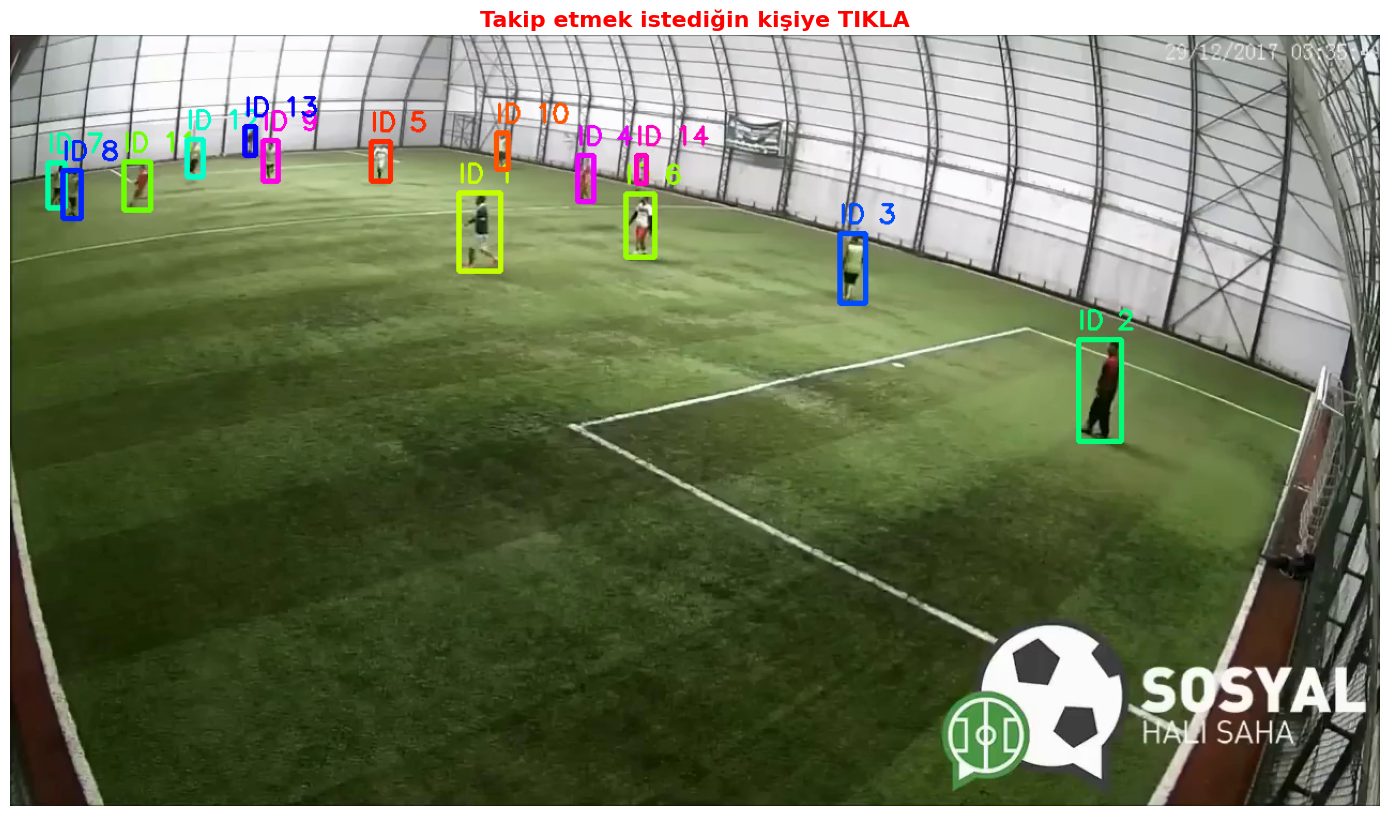

Pencere açıldı - bir kişiye tıkla ve bekle...
❌ Hiç kimse seçilmedi, işlem iptal


In [2]:
# INTERACTIVE SELECTION - Original Video + Selected Person Bird View
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import time

# ---------- CONFIG ----------
VIDEO_PATH = "shs2.mp4"
OUTPUT_PATH = "shs2_selected_tracking_bird10.mp4"
YOLO_MODEL = "yolov8m.pt"

# Bird view config
SRC_POINTS = np.float32([[-80, 130], [450, 1900], [400, 100], [1230, 320]])
DST_POINTS = np.float32([[50, 50], [50, 550], [350, 50], [350, 550]])
BIRD_WIDTH = 500
BIRD_HEIGHT = 600

FIELD_WIDTH_M = 15.0
FIELD_HEIGHT_M = 30.0
PIXELS_PER_METER_X = 300.0 / FIELD_WIDTH_M
PIXELS_PER_METER_Y = 500.0 / FIELD_HEIGHT_M

MIN_TRACK_LIFE = 20

# ---------- STEP 1: LOAD FIRST FRAME & DETECT ----------
print("Loading YOLO model:", YOLO_MODEL)
yolo = YOLO(YOLO_MODEL)

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")

ret, first_frame = cap.read()
if not ret:
    raise RuntimeError("Cannot read first frame")

print("Detecting persons in first frame...")
results = yolo.track(
    first_frame,
    persist=True,
    tracker="botsort.yaml",
    classes=[0],
    conf=0.25,
    iou=0.4,
    imgsz=1280,
    verbose=False
)[0]

if results.boxes is None or len(results.boxes) == 0:
    raise RuntimeError("No persons detected in first frame")

boxes = results.boxes.xyxy.cpu().numpy()
track_ids = results.boxes.id.cpu().numpy().astype(int) if results.boxes.id is not None else None

if track_ids is None:
    raise RuntimeError("No track IDs in first frame")

print(f"Found {len(track_ids)} persons in first frame")

# Draw all detected persons
display_frame = first_frame.copy()
person_info = []

for i, track_id in enumerate(track_ids):
    x1, y1, x2, y2 = map(int, boxes[i])
    
    # Color per ID
    hue = (track_id * 37) % 180
    color = tuple(map(int, cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0]))
    
    cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 3)
    cv2.putText(display_frame, f"ID {track_id}", (x1, y1 - 10),
               cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    
    person_info.append({
        'id': track_id,
        'bbox': (x1, y1, x2, y2),
        'center': ((x1 + x2) // 2, (y1 + y2) // 2)
    })

# ---------- STEP 2: INTERACTIVE SELECTION ----------
print("\n" + "="*70)
print("FARE İLE TAKİP ETMEK İSTEDİĞİN KİŞİYİ SEÇ:")
print("- Bir kişinin üzerine TIKLA")
print("- Pencereyi KAPATMA, sadece tıkla!")
print("="*70 + "\n")

selected_id = None

def onclick(event):
    global selected_id
    if event.xdata is None or event.ydata is None:
        return
    
    click_x, click_y = int(event.xdata), int(event.ydata)
    
    # Find clicked person
    for person in person_info:
        x1, y1, x2, y2 = person['bbox']
        if x1 <= click_x <= x2 and y1 <= click_y <= y2:
            selected_id = person['id']
            print(f"✓ SEÇİLDİ: ID {selected_id}")
            plt.close()
            return

# Show frame with matplotlib - INTERACTIVE MODE
plt.ion()
fig, ax = plt.subplots(figsize=(14, 9))
ax.imshow(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
ax.set_title("Takip etmek istediğin kişiye TIKLA", fontsize=16, fontweight='bold', color='red')
ax.axis('off')
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()
plt.draw()
plt.pause(0.1)

print("Pencere açıldı - bir kişiye tıkla ve bekle...")

# Wait for selection
while selected_id is None and plt.fignum_exists(fig.number):
    plt.pause(0.1)

plt.ioff()
if plt.fignum_exists(fig.number):
    plt.close(fig)

if selected_id is None:
    print("❌ Hiç kimse seçilmedi, işlem iptal")
    cap.release()
else:
    print(f"\n✓ ID {selected_id} seçildi, video işleme başlıyor...\n")
    
    # ---------- STEP 3: PROCESS VIDEO ----------
    cap.release()
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Output: Original video + Bird view
    output_width = width + BIRD_WIDTH
    output_height = max(height, BIRD_HEIGHT)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (output_width, output_height))
    
    print(f"Video: {width}x{height} @ {fps:.1f} fps, {total_frames} frames")
    
    # Tracking state
    matrix = cv2.getPerspectiveTransform(SRC_POINTS, DST_POINTS)
    bird_trajectory = deque(maxlen=300)
    trajectories = defaultdict(lambda: deque(maxlen=60))
    id_life = defaultdict(int)
    
    total_distance = 0.0
    last_bird_pos = None
    
    frame_idx = 0
    person_found_count = 0
    t0 = time.time()
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_idx += 1
        if frame_idx % 30 == 0:
            elapsed = time.time() - t0
            print(f"Frame {frame_idx}/{total_frames} ({100*frame_idx/total_frames:.1f}%) - {elapsed:.1f}s")
        
        # Track all persons with BoT-SORT
        results = yolo.track(
            frame,
            persist=True,
            tracker="botsort.yaml",
            classes=[0],
            conf=0.25,
            iou=0.4,
            imgsz=1280,
            verbose=False
        )[0]
        
        # Create bird view
        bird_view = np.ones((BIRD_HEIGHT, BIRD_WIDTH, 3), dtype=np.uint8) * 40
        cv2.rectangle(bird_view, (50, 50), (350, 550), (255, 255, 255), 2)
        cv2.line(bird_view, (50, 300), (350, 300), (255, 255, 255), 1)
        cv2.circle(bird_view, (200, 300), 30, (255, 255, 255), 1)
        
        cv2.putText(bird_view, f"ID {selected_id} Tracking", (20, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
        cv2.putText(bird_view, f"Saha: {FIELD_WIDTH_M:.0f}m x {FIELD_HEIGHT_M:.0f}m", 
                   (10, BIRD_HEIGHT - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (180, 180, 180), 1)
        
        selected_person_found = False
        
        # Process all detections (but only draw selected person)
        if results.boxes is not None and results.boxes.id is not None:
            boxes = results.boxes.xyxy.cpu().numpy()
            track_ids = results.boxes.id.cpu().numpy().astype(int)
            
            for i, track_id in enumerate(track_ids):
                x1, y1, x2, y2 = map(int, boxes[i])
                
                id_life[track_id] += 1
                
                # ONLY process the selected person
                if track_id != selected_id:
                    continue
                
                # Only draw stable tracks
                if id_life[track_id] < MIN_TRACK_LIFE:
                    continue
                
                # Color for selected person
                hue = (track_id * 37) % 180
                color = tuple(map(int, cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0]))
                
                # Trajectory
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                trajectories[track_id].append((center_x, center_y))
                
                # Draw bbox on original frame (THICK)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 5)
                
                # Label
                label = f">>> ID {track_id} <<<"
                
                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
                cv2.rectangle(frame, (x1, y1 - 35), (x1 + label_size[0] + 15, y1), color, -1)
                cv2.putText(frame, label, (x1 + 7, y1 - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                
                # Draw trajectory on frame
                if len(trajectories[track_id]) > 1:
                    points = list(trajectories[track_id])
                    for j in range(len(points) - 1):
                        alpha = (j + 1) / len(points)
                        traj_thickness = max(3, int(alpha * 7))
                        cv2.line(frame, points[j], points[j + 1], color, traj_thickness)
                
                # This is the selected person
                if track_id == selected_id:
                    selected_person_found = True
                    person_found_count += 1
                    
                    # Bird view position
                    foot_x = center_x
                    foot_y = y2
                    
                    point = np.array([[foot_x, foot_y]], dtype=np.float32)
                    transformed = cv2.perspectiveTransform(point.reshape(-1, 1, 2), matrix)
                    bird_x, bird_y = int(transformed[0][0][0]), int(transformed[0][0][1])
                    
                    bird_trajectory.append((bird_x, bird_y))
                    
                    # Calculate distance
                    if last_bird_pos is not None:
                        dx_m = (bird_x - last_bird_pos[0]) / PIXELS_PER_METER_X
                        dy_m = (bird_y - last_bird_pos[1]) / PIXELS_PER_METER_Y
                        total_distance += np.sqrt(dx_m**2 + dy_m**2)
                    last_bird_pos = (bird_x, bird_y)
                    
                    # Draw on bird view
                    if 0 <= bird_x < BIRD_WIDTH and 0 <= bird_y < BIRD_HEIGHT:
                        # Trajectory
                        if len(bird_trajectory) > 1:
                            bird_points = list(bird_trajectory)
                            for j in range(len(bird_points) - 1):
                                bx1, by1 = bird_points[j]
                                bx2, by2 = bird_points[j + 1]
                                if 0 <= bx1 < BIRD_WIDTH and 0 <= by1 < BIRD_HEIGHT and \
                                   0 <= bx2 < BIRD_WIDTH and 0 <= by2 < BIRD_HEIGHT:
                                    alpha = (j + 1) / len(bird_points)
                                    thickness = max(2, int(alpha * 5))
                                    cv2.line(bird_view, (bx1, by1), (bx2, by2), (0, 255, 255), thickness)
                        
                        # Current position
                        cv2.circle(bird_view, (bird_x, bird_y), 14, (0, 255, 0), -1)
                        cv2.circle(bird_view, (bird_x, bird_y), 14, (255, 255, 255), 3)
                        cv2.putText(bird_view, str(selected_id), (bird_x - 10, bird_y + 6),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        # Stats on bird view
        if selected_person_found:
            status_color = (0, 255, 0)
            status_text = "TRACKING"
        else:
            status_color = (0, 0, 255)
            status_text = "LOST"
        
        cv2.putText(bird_view, f"Status: {status_text}", (20, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, status_color, 2)
        cv2.putText(bird_view, f"Distance: {total_distance:.1f}m", (20, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Large distance display at bottom
        cv2.rectangle(bird_view, (50, BIRD_HEIGHT - 80), (350, BIRD_HEIGHT - 20), (0, 0, 0), -1)
        cv2.putText(bird_view, f"{total_distance:.1f} m", (80, BIRD_HEIGHT - 35),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 4)
        
        # Combine frames
        combined = np.zeros((output_height, output_width, 3), dtype=np.uint8)
        combined[:height, :width] = frame
        combined[:BIRD_HEIGHT, width:width+BIRD_WIDTH] = bird_view
        
        out.write(combined)
    
    cap.release()
    out.release()
    
    elapsed = time.time() - t0
    
    print(f"\n{'='*70}")
    print(f"✓ İŞLEM TAMAMLANDI: {elapsed:.1f}s")
    print(f"✓ Çıktı: {OUTPUT_PATH}")
    print(f"✓ Seçilen ID: {selected_id}")
    print(f"✓ Toplam mesafe: {total_distance:.1f}m")
    print(f"✓ Görülme: {person_found_count}/{total_frames} frame ({100*person_found_count/total_frames:.1f}%)")
    print(f"{'='*70}")


## 🎯 İnteraktif Seçim - Orijinal Video + Kuş Bakışı

Bu hücre, **sadece seçilen kişinin** orijinal videoda takip edilmesini sağlar. Diğer kişiler gösterilmez.

### Çıktı Düzeni:
- **Sol (Orijinal Video)**: Sadece seçilen kişi gösterilir
  - Kalın bbox (5px)
  - >>> ID X <<< etiketi
  - Trajectory çizgisi
  - Tüm sahada hareket görünür
  
- **Sağ (Kuş Bakışı)**: Seçilen kişinin top-down görünümü
  - Sarı trajectory
  - Yeşil pozisyon noktası
  - Gerçek zamanlı mesafe (metre)
  - Status: TRACKING/LOST

### Farklar:
- ❌ Diğer kişiler detection yapılmaz
- ✅ Sadece seçilen kişi vurgulanır
- ✅ Daha temiz görüntü
- ✅ İşlem hızı daha yüksek

### Çıktı:
`shs2_selected_tracking_bird.mp4`

In [ ]:
# INTERACTIVE SELECTION + SAM SEGMENTATION - Original Video + Bird View
import cv2
import numpy as np
from ultralytics import YOLO, SAM
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import time

# ---------- CONFIG ----------
VIDEO_PATH = "shs2.mp4"
OUTPUT_PATH = "shs2_selected_sam_tracking.mp4"
YOLO_MODEL = "yolov8m.pt"
SAM_MODEL_PATH = r'C:\Users\User\Desktop\MobileSAM\mobile_sam.pt'

# Bird view config
SRC_POINTS = np.float32([[-80, 130], [450, 1900], [400, 100], [1230, 320]])
DST_POINTS = np.float32([[50, 50], [50, 550], [350, 50], [350, 550]])
BIRD_WIDTH = 500
BIRD_HEIGHT = 600

FIELD_WIDTH_M = 15.0
FIELD_HEIGHT_M = 30.0
PIXELS_PER_METER_X = 300.0 / FIELD_WIDTH_M
PIXELS_PER_METER_Y = 500.0 / FIELD_HEIGHT_M

MIN_TRACK_LIFE = 20

# ---------- STEP 1: LOAD MODELS ----------
print("Loading YOLO model:", YOLO_MODEL)
yolo = YOLO(YOLO_MODEL)

print("Loading MobileSAM model:", SAM_MODEL_PATH)
sam_model = SAM(SAM_MODEL_PATH)

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")

ret, first_frame = cap.read()
if not ret:
    raise RuntimeError("Cannot read first frame")

print("Detecting persons in first frame...")
results = yolo.track(
    first_frame,
    persist=True,
    tracker="botsort.yaml",
    classes=[0],
    conf=0.25,
    iou=0.4,
    imgsz=1280,
    verbose=False
)[0]

if results.boxes is None or len(results.boxes) == 0:
    raise RuntimeError("No persons detected in first frame")

boxes = results.boxes.xyxy.cpu().numpy()
track_ids = results.boxes.id.cpu().numpy().astype(int) if results.boxes.id is not None else None

if track_ids is None:
    raise RuntimeError("No track IDs in first frame")

print(f"Found {len(track_ids)} persons in first frame")

# Draw all detected persons
display_frame = first_frame.copy()
person_info = []

for i, track_id in enumerate(track_ids):
    x1, y1, x2, y2 = map(int, boxes[i])
    
    # Color per ID
    hue = (track_id * 37) % 180
    color = tuple(map(int, cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0]))
    
    cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 3)
    cv2.putText(display_frame, f"ID {track_id}", (x1, y1 - 10),
               cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    
    person_info.append({
        'id': track_id,
        'bbox': (x1, y1, x2, y2),
        'center': ((x1 + x2) // 2, (y1 + y2) // 2)
    })

# ---------- STEP 2: INTERACTIVE SELECTION ----------
print("\n" + "="*70)
print("FARE İLE SAM SEGMENTATION YAPMAK İSTEDİĞİN KİŞİYİ SEÇ:")
print("- Bir kişinin üzerine TIKLA")
print("- Pencereyi KAPATMA, sadece tıkla!")
print("="*70 + "\n")

selected_id = None

def onclick(event):
    global selected_id
    if event.xdata is None or event.ydata is None:
        return
    
    click_x, click_y = int(event.xdata), int(event.ydata)
    
    # Find clicked person
    for person in person_info:
        x1, y1, x2, y2 = person['bbox']
        if x1 <= click_x <= x2 and y1 <= click_y <= y2:
            selected_id = person['id']
            print(f"✓ SEÇİLDİ: ID {selected_id} - SAM segmentation uygulanacak")
            plt.close()
            return

# Show frame with matplotlib - INTERACTIVE MODE
plt.ion()
fig, ax = plt.subplots(figsize=(14, 9))
ax.imshow(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
ax.set_title("SAM segmentation için kişiye TIKLA", fontsize=16, fontweight='bold', color='red')
ax.axis('off')
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()
plt.draw()
plt.pause(0.1)

print("Pencere açıldı - bir kişiye tıkla ve bekle...")

# Wait for selection
while selected_id is None and plt.fignum_exists(fig.number):
    plt.pause(0.1)

plt.ioff()
if plt.fignum_exists(fig.number):
    plt.close(fig)

if selected_id is None:
    print("❌ Hiç kimse seçilmedi, işlem iptal")
    cap.release()
else:
    print(f"\n✓ ID {selected_id} seçildi, SAM segmentation + tracking başlıyor...\n")
    
    # ---------- STEP 3: PROCESS VIDEO WITH SAM ----------
    cap.release()
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Output: Original video + Bird view
    output_width = width + BIRD_WIDTH
    output_height = max(height, BIRD_HEIGHT)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (output_width, output_height))
    
    print(f"Video: {width}x{height} @ {fps:.1f} fps, {total_frames} frames")
    
    # Tracking state
    matrix = cv2.getPerspectiveTransform(SRC_POINTS, DST_POINTS)
    bird_trajectory = deque(maxlen=300)
    trajectories = defaultdict(lambda: deque(maxlen=60))
    id_life = defaultdict(int)
    
    total_distance = 0.0
    last_bird_pos = None
    
    frame_idx = 0
    person_found_count = 0
    t0 = time.time()
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_idx += 1
        if frame_idx % 30 == 0:
            elapsed = time.time() - t0
            print(f"Frame {frame_idx}/{total_frames} ({100*frame_idx/total_frames:.1f}%) - {elapsed:.1f}s")
        
        # Track all persons with BoT-SORT
        results = yolo.track(
            frame,
            persist=True,
            tracker="botsort.yaml",
            classes=[0],
            conf=0.25,
            iou=0.4,
            imgsz=1280,
            verbose=False
        )[0]
        
        # Create bird view
        bird_view = np.ones((BIRD_HEIGHT, BIRD_WIDTH, 3), dtype=np.uint8) * 40
        cv2.rectangle(bird_view, (50, 50), (350, 550), (255, 255, 255), 2)
        cv2.line(bird_view, (50, 300), (350, 300), (255, 255, 255), 1)
        cv2.circle(bird_view, (200, 300), 30, (255, 255, 255), 1)
        
        cv2.putText(bird_view, f"ID {selected_id} + SAM", (20, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
        cv2.putText(bird_view, f"Saha: {FIELD_WIDTH_M:.0f}m x {FIELD_HEIGHT_M:.0f}m", 
                   (10, BIRD_HEIGHT - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (180, 180, 180), 1)
        
        selected_person_found = False
        
        # Process detections - ONLY selected person
        if results.boxes is not None and results.boxes.id is not None:
            boxes = results.boxes.xyxy.cpu().numpy()
            track_ids = results.boxes.id.cpu().numpy().astype(int)
            
            for i, track_id in enumerate(track_ids):
                x1, y1, x2, y2 = map(int, boxes[i])
                
                id_life[track_id] += 1
                
                # ONLY process the selected person
                if track_id != selected_id:
                    continue
                
                # Only draw stable tracks
                if id_life[track_id] < MIN_TRACK_LIFE:
                    continue
                
                # Color for selected person
                hue = (track_id * 37) % 180
                color = tuple(map(int, cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0]))
                
                # ========== SAM SEGMENTATION ==========
                # Run SAM on bbox
                sam_results = sam_model(frame, bboxes=[[x1, y1, x2, y2]], verbose=False)
                
                if sam_results and len(sam_results) > 0 and sam_results[0].masks is not None:
                    # Get mask
                    mask = sam_results[0].masks.data[0].cpu().numpy()
                    mask_uint8 = (mask * 255).astype(np.uint8)
                    
                    # Create colored overlay
                    overlay = frame.copy()
                    colored_mask = np.zeros_like(frame)
                    colored_mask[mask > 0.5] = color
                    
                    # Blend overlay
                    cv2.addWeighted(colored_mask, 0.5, overlay, 1.0, 0, overlay)
                    frame = overlay
                    
                    # Draw contour around mask
                    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    if contours:
                        cv2.drawContours(frame, contours, -1, color, 4)
                else:
                    # Fallback to bbox if SAM fails
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 5)
                
                # Label
                label = f">>> ID {track_id} (SAM) <<<"
                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
                cv2.rectangle(frame, (x1, y1 - 35), (x1 + label_size[0] + 15, y1), color, -1)
                cv2.putText(frame, label, (x1 + 7, y1 - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                
                # Trajectory
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                trajectories[track_id].append((center_x, center_y))
                
                # Draw trajectory on frame
                if len(trajectories[track_id]) > 1:
                    points = list(trajectories[track_id])
                    for j in range(len(points) - 1):
                        alpha = (j + 1) / len(points)
                        traj_thickness = max(3, int(alpha * 7))
                        cv2.line(frame, points[j], points[j + 1], color, traj_thickness)
                
                # Mark as found
                selected_person_found = True
                person_found_count += 1
                
                # Bird view position
                foot_x = center_x
                foot_y = y2
                
                point = np.array([[foot_x, foot_y]], dtype=np.float32)
                transformed = cv2.perspectiveTransform(point.reshape(-1, 1, 2), matrix)
                bird_x, bird_y = int(transformed[0][0][0]), int(transformed[0][0][1])
                
                bird_trajectory.append((bird_x, bird_y))
                
                # Calculate distance
                if last_bird_pos is not None:
                    dx_m = (bird_x - last_bird_pos[0]) / PIXELS_PER_METER_X
                    dy_m = (bird_y - last_bird_pos[1]) / PIXELS_PER_METER_Y
                    total_distance += np.sqrt(dx_m**2 + dy_m**2)
                last_bird_pos = (bird_x, bird_y)
                
                # Draw on bird view
                if 0 <= bird_x < BIRD_WIDTH and 0 <= bird_y < BIRD_HEIGHT:
                    # Trajectory
                    if len(bird_trajectory) > 1:
                        bird_points = list(bird_trajectory)
                        for j in range(len(bird_points) - 1):
                            bx1, by1 = bird_points[j]
                            bx2, by2 = bird_points[j + 1]
                            if 0 <= bx1 < BIRD_WIDTH and 0 <= by1 < BIRD_HEIGHT and \
                               0 <= bx2 < BIRD_WIDTH and 0 <= by2 < BIRD_HEIGHT:
                                alpha = (j + 1) / len(bird_points)
                                thickness = max(2, int(alpha * 5))
                                cv2.line(bird_view, (bx1, by1), (bx2, by2), (0, 255, 255), thickness)
                    
                    # Current position
                    cv2.circle(bird_view, (bird_x, bird_y), 14, (0, 255, 0), -1)
                    cv2.circle(bird_view, (bird_x, bird_y), 14, (255, 255, 255), 3)
                    cv2.putText(bird_view, str(selected_id), (bird_x - 10, bird_y + 6),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        # Stats on bird view
        if selected_person_found:
            status_color = (0, 255, 0)
            status_text = "TRACKING + SAM"
        else:
            status_color = (0, 0, 255)
            status_text = "LOST"
        
        cv2.putText(bird_view, f"Status: {status_text}", (20, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.65, status_color, 2)
        cv2.putText(bird_view, f"Distance: {total_distance:.1f}m", (20, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Large distance display at bottom
        cv2.rectangle(bird_view, (50, BIRD_HEIGHT - 80), (350, BIRD_HEIGHT - 20), (0, 0, 0), -1)
        cv2.putText(bird_view, f"{total_distance:.1f} m", (80, BIRD_HEIGHT - 35),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 4)
        
        # Combine frames
        combined = np.zeros((output_height, output_width, 3), dtype=np.uint8)
        combined[:height, :width] = frame
        combined[:BIRD_HEIGHT, width:width+BIRD_WIDTH] = bird_view
        
        out.write(combined)
    
    cap.release()
    out.release()
    
    elapsed = time.time() - t0
    
    print(f"\n{'='*70}")
    print(f"✓ SAM SEGMENTATION + TRACKING TAMAMLANDI: {elapsed:.1f}s")
    print(f"✓ Çıktı: {OUTPUT_PATH}")
    print(f"✓ Seçilen ID: {selected_id}")
    print(f"✓ Toplam mesafe: {total_distance:.1f}m")
    print(f"✓ Görülme: {person_found_count}/{total_frames} frame ({100*person_found_count/total_frames:.1f}%)")
    print(f"{'='*70}")


## 🎨 İnteraktif Seçim + SAM Segmentation

Bu hücre, seçilen kişiye **MobileSAM segmentation** uygular. Bbox yerine kişinin tam şeklini (silüetini) tespit eder.

### SAM (Segment Anything Model):
- **Model**: MobileSAM (hafif, hızlı)
- **Yöntem**: Bbox'tan mask üretimi
- **Görselleştirme**: 
  - Renkli overlay (0.5 alpha)
  - Contour çizimi (4px)
  - Fallback: SAM başarısız olursa bbox

### Avantajlar:
- ✅ Piksel seviyesinde hassasiyet
- ✅ Kişinin tam şekli görünür
- ✅ Daha profesyonel görünüm
- ✅ Arka plan ayrımı net

### Çıktı Düzeni:
- **Sol**: Orijinal video + SAM segmentation
- **Sağ**: Kuş bakışı + mesafe tracking

### Performans:
- SAM her frame için çalışır
- İşlem süresi: Normal takipten ~30-40% daha uzun
- Sonuç: Daha kaliteli görselleştirme

### Çıktı:
`shs2_selected_sam_tracking.mp4`